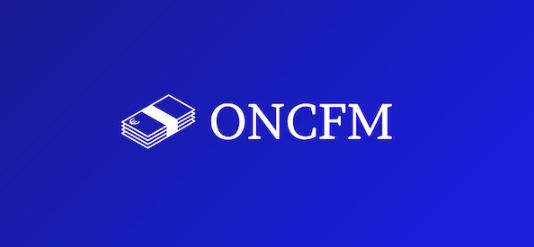

# P10 - PROJET DE DETECTION AUTOMATIQUE DES FAUX BILLETS

# I- IMPORT DES LIBRAIRIES

### 1 - IMPORT DES LIBRAIRIES

In [1]:
# les essentiels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# statmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# scipy
from scipy.stats import t, levene

# sklearn
from sklearn import decomposition
from sklearn import metrics
from sklearn import cluster
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### 2 - FONCTIONS

In [2]:
# Fonction permettant la création des graphs de corrélations qui serviront à analyser notre ACP: 

def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10,8))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # setup des flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],
                head_width=0.04,
                head_length=0.04, 
                width=0.01, )
        
        # création de valeur aléatoire qui vont permettre d'éviter le chevauchement des labels dans le graph
        random_value_A = np.random.uniform(0.00,0.07)
        random_value_B = np.random.uniform(0.00,0.07)

        # setup des labels en utilisant les valeurs aléatoires précédemment définies
        plt.text(pca.components_[x, i]+ random_value_A,
                 pca.components_[y, i]+ random_value_B,
                features[i])  
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # Nommage du graph de correlations
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Création du cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Setup axes et display
    plt.axis('equal')
    plt.show(block=False)

# II - IMPORT DES DONNÉES

In [3]:
# Import des données
df_billet = pd.read_csv("billets.csv", sep = ';',)

# III - EXPLORATION DES DONNÉES

## 1 - EXPLORATION / VISUALISATION DES DONNÉES ET DESCRIPTION DES VARIABLES

In [4]:
# Visualisation des premières lignes
df_billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [5]:
# Visualisation des dernières lignes
df_billet.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25
1499,False,171.47,104.15,103.82,4.63,3.37,112.07


In [6]:
# Visualisation nombre de lignes et nombre de variables
df_billet.shape

(1500, 7)

<b> Le dataset contient les informations de 1500 billets.

<b>Nous disposons de six variables géométriques :
- length : la longueur du billet (en mm) 
- height_left : la hauteur du billet (mesurée sur le côté gauche, en
mm) 
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) 
- margin_up : la marge entre le bord supérieur du billet et l'image de
celui-ci (en mm) 
- margin_low : la marge entre le bord inférieur du billet et l'image de
celui-ci (en mm) 
- diagonal : la diagonale du billet (en mm).

<b>Et d'une variable booléenne (True / False) :</b> is_genuine 


In [7]:
# Visualisation des variables, des valeurs non-nulles, des types de variables
df_billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


<b> Attention : pour 37 lignes, l'information de la variable margin_low est manquante
    
Cette variable correspond à "la marge entre le bord inférieur du billet et l'image de celui-ci (en mm)". 

Les différents types de données semblent être adaptés pour l'ensemble des variables (float pour les données géométriques et booléen pour is_genuine).</b>


In [8]:
# Visualisation min/max/std/moyenne/quartiles pour chaque variable
df_billet.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [9]:
# Visualisation des valeurs uniques pour 'is_genuine'
df_billet['is_genuine'].unique()

array([ True, False])

In [10]:
# Visualisation des individus ayant une valeur "True" pour 'is_genuine' (vrais billets)
vrais_billets = df_billet.loc[df_billet['is_genuine'] == True,:]
vrais_billets.count()

is_genuine      1000
diagonal        1000
height_left     1000
height_right    1000
margin_low       971
margin_up       1000
length          1000
dtype: int64

In [11]:
# Visualisation min/max/std/moyenne/quartiles pour chaque variable des vrais billets
vrais_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.000000,1000.000000,1000.00000,971.000000,1000.00000,1000.000000
mean,171.987080,103.949130,103.80865,4.116097,3.05213,113.202430
std,0.300441,0.300231,0.29157,0.319124,0.18634,0.359552
min,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,171.790000,103.740000,103.61000,3.905000,2.93000,112.950000
50%,171.990000,103.950000,103.81000,4.110000,3.05000,113.205000
75%,172.200000,104.140000,104.00000,4.340000,3.18000,113.460000
max,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


In [12]:
# Visualisation des individus ayant une valeur "False" pour 'is_genuine' (faux billets)
faux_billets = df_billet.loc[df_billet['is_genuine'] == False,:]
faux_billets.count()

is_genuine      500
diagonal        500
height_left     500
height_right    500
margin_low      492
margin_up       500
length          500
dtype: int64

In [13]:
# Visualisation min/max/std/moyenne/quartiles pour chaque variable des faux billets
faux_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.000000,500.000000,500.000000,492.000000,500.000000,500.000000
mean,171.901160,104.190340,104.143620,5.215935,3.350160,111.630640
std,0.306861,0.223758,0.270878,0.553531,0.180498,0.615543
min,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,171.910000,104.180000,104.160000,5.190000,3.350000,111.630000
75%,172.092500,104.332500,104.320000,5.592500,3.472500,112.030000
max,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


Text(0.5, 1.0, 'Répartition vrais / faux billets')

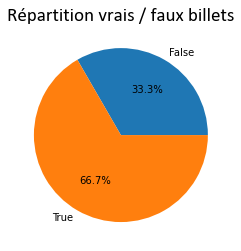

In [14]:
# Comptage du nombre de lignes correspondant à chaque valeur distincte de la variable 'is_genuine'
df_true_false = df_billet.groupby(['is_genuine']).count().reset_index()

# Créer un pie-chart
plt.pie(labels=df_true_false['is_genuine'], x=df_true_false['diagonal'], autopct='%.1f%%')
plt.title("Répartition vrais / faux billets", fontname='Calibri', fontsize=19)

Le dataset de base contient les informations de 500 faux billets (1/3) et 1000 vrais billets (2/3). 

<AxesSubplot:xlabel='is_genuine', ylabel='diagonal'>

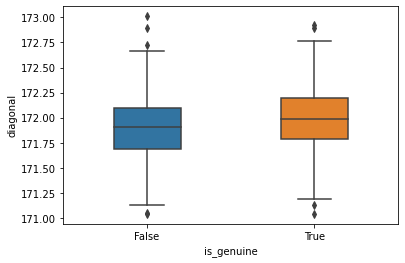

In [15]:
# Génération d'un boxplot croisant les variables 'is_genuine' et 'diagonal'
sns.boxplot(data=df_billet,y='diagonal',x='is_genuine',width=0.4)

<AxesSubplot:xlabel='is_genuine', ylabel='height_left'>

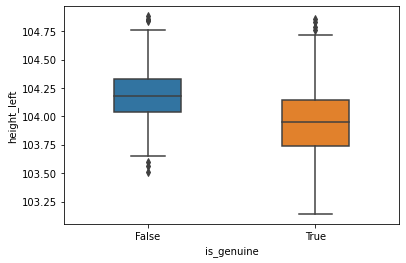

In [16]:
# Génération d'un boxplot croisant les variables 'is_genuine' et 'height_left'
sns.boxplot(data=df_billet,y='height_left',x='is_genuine',width=0.4)

<AxesSubplot:xlabel='is_genuine', ylabel='height_right'>

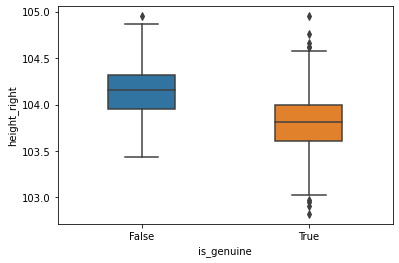

In [17]:
# Génération d'un boxplot croisant les variables 'is_genuine' et 'height_right'
sns.boxplot(data=df_billet,y='height_right',x='is_genuine',width=0.4)

<AxesSubplot:xlabel='is_genuine', ylabel='margin_low'>

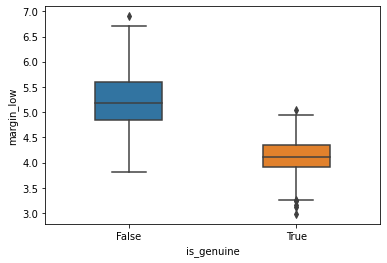

In [18]:
# Génération d'un boxplot croisant les variables 'is_genuine' et 'margin_low'
sns.boxplot(data=df_billet,y='margin_low',x='is_genuine',width=0.4)

<AxesSubplot:xlabel='is_genuine', ylabel='margin_up'>

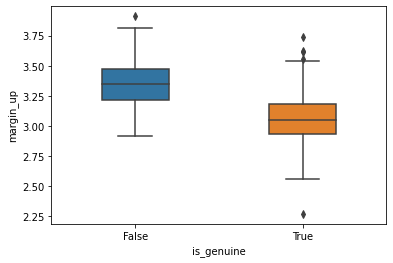

In [19]:
# Génération d'un boxplot croisant les variables 'is_genuine' et 'margin_up'
sns.boxplot(data=df_billet,y='margin_up',x='is_genuine',width=0.4)

<AxesSubplot:xlabel='is_genuine', ylabel='length'>

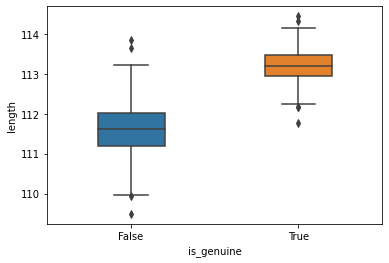

In [20]:
# Génération d'un boxplot croisant les variables 'is_genuine' et 'length'
sns.boxplot(data=df_billet,y='length',x='is_genuine',width=0.4)

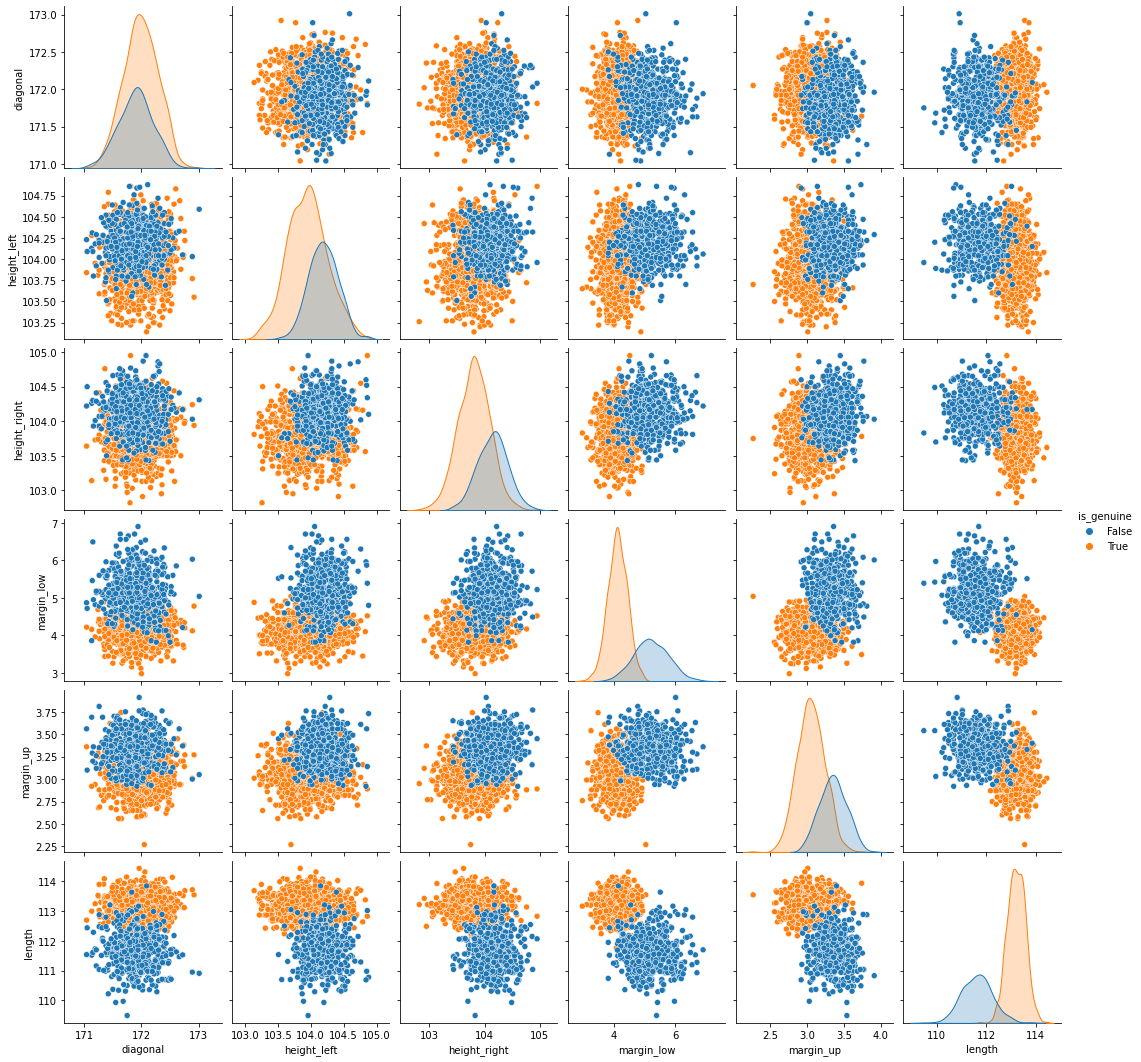

In [21]:
# Visualisation des individus (bleu = faux / orange = vrai) pour chaque croisement de variables
df_pairplot = df_billet
sns.pairplot(df_pairplot, hue='is_genuine')

Observations : 
- 'margin_low' et 'length' semblent avoir une très forte corrélation (le croisement des deux variables offre un nuage de points avec 2 sous-ensembles distincts).
- Visuellement, l'ensemble des variables semblent suivre une loi normale. 


<AxesSubplot:>

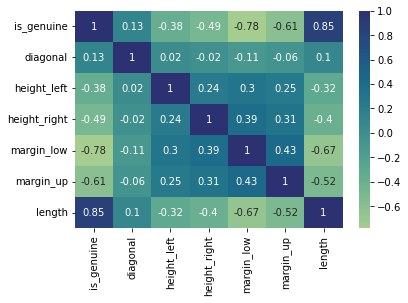

In [22]:
# Affichage du graphique de corrélation des variables
sns.heatmap(df_billet.corr().round(2), annot=True, cmap="crest")

On remarque que 'is_genuine' est principalement corrélée aux variables 'length' (corrélation positive) et 'margin_low' (corrélation négative). Cela confirme les premières observations des boxplots de croisement de variables.

# IV - RETRAITEMENT DES DONNÉES : GESTION DES VALEURS MANQUANTES VIA REGRESSION LINEAIRE
Afin de récupérer les informations manquantes (NaN) pour la variable "<i>margin_low</i>" nous allons recourir à une régression linéaire multiple. Celle-ci sert à prévoir la valeur d'une variable (ici 'margin_low') en fonction de la valeur d'une ou plusieurs autres variables.

## 1 - SETUP DU DATAFRAME 

In [23]:
# Création d'un dataframe contenant seulement les lignes avec NaN,
# sur lequel nous appliquerons notre modèle de prédiction
df_na = df_billet[df_billet['margin_low'].isna()]
df_na.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


In [24]:
# Création d'un dataframe contenant seulement les lignes sans NaN, 
# qui servira à entrainer et tester notre modèle de prédiction
df_wo_na = df_billet.copy()
df_wo_na = df_wo_na.dropna()
df_wo_na.shape

(1463, 7)

## 2 - SELECTION DES VARIABLES SIGNIFICATIVES

#### A - EXCUTION DU MODELE SUR L'ENSEMBLE DES VARIABLES 

On utilise la librairie <i>statsmodels</i> pour réaliser une regression multiple afin de retrouver les valeurs manquantes de 'margin_low' en fonction des autres variables de l'échantillon.

In [25]:
# Création des train sets et test sets 
X = df_wo_na.copy()
X = X.drop(columns = ['margin_low', 'is_genuine']) # toutes les colonnes sauf la target et la colonne is_genuine
y = pd.DataFrame(df_wo_na['margin_low']) # colonne target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8) # split 70% train 30% test

In [26]:
# Entrainement du modèle de régression lineaire multiple
model_multi_lin_reg = sm.OLS(y_train, X_train).fit()

print(model_multi_lin_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:             margin_low   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          1.764e+04
Date:                Sat, 29 Apr 2023   Prob (F-statistic):                        0.00
Time:                        16:25:57   Log-Likelihood:                         -716.58
No. Observations:                1024   AIC:                                      1443.
Df Residuals:                    1019   BIC:                                      1468.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

Les résultats de l'OLS donnent les informations suivantes :

R-squared = 0.989 : cela signifie que 98.9 % de la variance de la variable "margin_low" est expliquée par le modèle.

Les variables "height_left", "height_right", "margin_up" et "length" ont des coefficients statistiquement significatifs (p-value < 0,05), seule 'diagonal' a une p-value > 0.05, elle est donc non-significative.

La valeur F-statistic est une mesure de la qualité globale du modèle de régression. Elle évalue la significativité de l'ensemble des variables explicatives dans le modèle par rapport à la variable dépendante. Dans ce tableau, la valeur F-statistic est très élevée (17640), avec une probabilité (Prob (F-statistic)) proche de zéro. Cela indique que l'ensemble des variables explicatives ('diagonal', 'height_left', 'height_right', 'margin_up' et 'length') sont significatives pour expliquer la variance de la variable dépendante ('margin_low').

Globalement, les résultats de l'OLS suggèrent que le modèle a une forte capacité à expliquer la variance de la variable "margin_low". 

Afin d'optimiser les performances du modèle, nous allons procéder à la suppression des variables non-significatives ('diagonal') et relancer l'entraînement du modèle.

#### B - EXCUTION DU MODELE SUR LES VARIABLES SIGNIFICATIVES

In [27]:
# Création des train sets et test sets 
X = df_wo_na.copy()
X = X.drop(columns = ['margin_low', 'is_genuine','diagonal']) # toutes les colonnes sauf la target et la colonne is_genuine
y = pd.DataFrame(df_wo_na['margin_low']) # colonne target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8) # split 70% train 30% test

In [28]:
# Training du model de regression lineaire multiple
model_multi_lin_reg = sm.OLS(y_train, X_train).fit()

print(model_multi_lin_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:             margin_low   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          2.204e+04
Date:                Sat, 29 Apr 2023   Prob (F-statistic):                        0.00
Time:                        16:25:57   Log-Likelihood:                         -717.27
No. Observations:                1024   AIC:                                      1443.
Df Residuals:                    1020   BIC:                                      1462.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

Ces nouveaux résultats exposent une valeur F-statistic plus élevée (22040), ce qui indique une plus grande significativité des variables. Le reste des informations sont globalement identiques.

## 3 - EVALUATION DU MODELE DE REGRESSION

In [29]:
# Prédiction des valeurs pour le test set
y_pred = model_multi_lin_reg.predict(X_test)

In [30]:
# Visualisation min/max/std/moyenne/quartiles pour la variable 'margin_low' prédite par le modèle
y_pred.describe()

count    439.000000
mean       4.440197
std        0.461324
min        3.701848
25%        4.104730
50%        4.293720
75%        4.803762
max        5.656079
dtype: float64

In [31]:
# Visualisation min/max/std/moyenne/quartiles pour la variable 'margin_low' disponible dans le fichier de test
df_wo_na['margin_low'].describe()

count    1463.000000
mean        4.485967
std         0.663813
min         2.980000
25%         4.015000
50%         4.310000
75%         4.870000
max         6.900000
Name: margin_low, dtype: float64

Les valeurs manquantes prédites via notre modèle de regression linéaire ne comportent pas de valeurs abbérantes, les valeurs min et max restent inférieures à celles présentes dans notre fichier initial, et les moyennes des valeurs sont très semblables entre les prédictions et les valeurs déjà présentes dans ce fichier.

### A - ANALYSE DE L'HYPOTHESE DE NORMALITÉ DE DISTRIBUTION DES RESIDUS

En général, il est important que les résidus d'un modèle de régression soient distribués normalement pour que les estimations de paramètres soient efficaces et pour que les tests d'hypothèses soient valides. Si les résidus ne sont pas distribués normalement, cela peut indiquer que le modèle ne capture pas toutes les sources de variation dans les données et peut compromettre les résultats de l'analyse.


#### 1 - Visualisation des résidus 

In [32]:
# Calcul des rédidus
y_pred = pd.DataFrame(y_pred)
residus = (y_test['margin_low'] - y_pred[0])
residus

1358    0.382958
489    -0.160981
934     0.168438
128    -0.182046
1346    0.354950
          ...   
1296   -0.517099
779     0.177201
637     0.788152
651    -0.101615
1181    1.040784
Length: 439, dtype: float64

In [33]:
# Visualisation min/max/std/moyenne/quartiles pour les résidus
residus.describe()

count    439.000000
mean      -0.002862
std        0.467397
min       -1.172468
25%       -0.286984
50%       -0.040501
75%        0.268460
max        1.979921
dtype: float64

L'analyse des résidus montre qu'en moyenne l'écart entre valeurs réelles et valeurs prédites est de -0.002. On remarque cependant que les erreurs vont de -1.17 à +1.98. Aucune valeur prédite ne dépasse néanmoins les valeurs min / max du fichier de test. 

C:\Users\ptigr\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

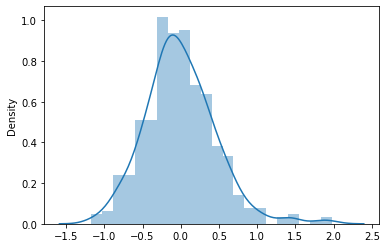

In [34]:
# Visualisation de la distribution des résidus
sns.distplot(residus)

On observe que la représentation graphique de la distribution des résidus présente une distribution globalement symétrique, avec des valeurs centrées autour de 0. 

#### 2 - Analyse Omnibus / Jarque-Bera

Plusieurs éléments issus des résultats de notre modèle nous permettent d'analyser l'hypothèse de normalité de la distribution des résidus. 

Omnibus est un test statistique qui évalue si les résidus du modèle sont distribués normalement ou non. Un faible Omnibus (proche de 1) indique que les résidus sont approximativement normaux, tandis qu'un Omnibus élevé suggère que les résidus ne sont pas normaux. Ici, la valeur s'élève à 28.01 ce qui rejette l'hypothèse de normalité de la distribution des résidus.

Prob(Omnibus) est la p-value associée au test Omnibus. Si cette valeur est faible (par exemple, <0,05), cela suggère que les résidus ne sont pas distribués normalement. Ici, la valeur est de 0 (donc <0.05) et vient donc confirmer que nos résidus ne sont pas distribués normalement.

Jarque-Bera (JB) est un autre test d'adéquation à la normalité des résidus d'un modèle de régression. Il évalue si les résidus sont distribués normalement en testant l'asymétrie et l'aplatissement de leur distribution par rapport à une distribution normale. Si le test est significatif (c'est-à-dire si la p-value est faible), cela suggère que les résidus ne sont pas distribués normalement. Ici, le score JB est de 31,49. Cette valeur suggère également que les résidus ne sont pas distribués normalement. Cette conclusion rejoint celle obtenue avec le test Omnibus.

### B - ANALYSE DE L'HYPOTHESE D'HOMOSCEDASTICITE DES RESIDUS

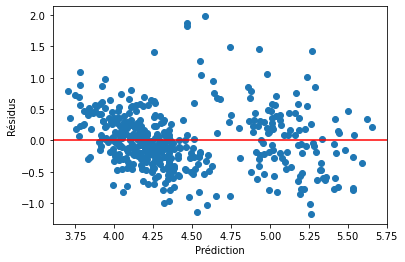

Statistique de test :  0.0015127533991917208
p-valeur :  0.968983657971631
Les résidus sont homoscédastiques


In [35]:
# Visualisation de la dispersion des résidus en fonction de la prédiction
plt.scatter(y_pred, residus)
plt.xlabel('Prédiction')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Test de Levene
stat, p = levene(residus, y_pred[0])
print('Statistique de test : ', stat)
print('p-valeur : ', p)
if p > 0.05:
    print('Les résidus sont homoscédastiques')
else:
    print('Les résidus ne sont pas homoscédastiques')

Le test de Levene est utilisé pour tester l'hypothèse d'homoscédasticité des résidus d'une régression linéaire. L'hypothèse nulle est que les variances des résidus sont égales pour tous les niveaux de la variable dépendante.

La p-valeur est de 0.969, ce qui est supérieur au seuil de significativité (0,05). Nous ne pouvons donc pas rejeter l'hypothèse nulle. Ainsi, nous pouvons dire que les résidus sont homoscédastiques, une condition importante pour la validité de la régression linéaire.

### C - ANALYSE DE L'HYPOTHESE DE COLINEARITE


In [36]:
# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test)

# Calcul des VIF pour les variables standardisées
vif = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Affichage des résultats
for i, vif_score in enumerate(vif):
    print(f"VIF pour la variable {X.columns[i]}: {vif_score:.2f}")

VIF pour la variable height_left: 1.16
VIF pour la variable height_right: 1.22
VIF pour la variable margin_up: 1.35
VIF pour la variable length: 1.53


Il est nécessaire de standardiser les données avant de calculer les VIF car cela permet de mettre toutes les variables à la même échelle et de faciliter ainsi la comparaison des VIF entre les variables.

Les résultats des VIF obtenus indiquent que la colinéarité entre les variables explicatives est faible. En général, un VIF inférieur à 5 indique qu'il n'y a pas de colinéarité importante dans le modèle.

Dans le cas présent, cela signifie que le modèle de régression est robuste et fiable pour l'interprétation des coefficients de régression et des prédictions.

### D - CONCLUSION

Ici , l'hypothèse de normalité des résidus est rejetée, ce qui peut impacter la qualité des prédictions de notre modèle. 

Nous allons tout de même utiliser ce modèle de regression pour réaliser les prédictions. Bien que celles-ci peuvent manquer d'exactitude, cette distribution reste globalement symétrique, avec une valeur moyenne des résidus proche de 0. Dans tous les cas, la régression linéaire est expressement demandée dans les guidelines qui nous ont étées remises. 

Il faut également relativiser l'impact d'une estimation approximative sur les prochaines étapes du projet, nous parlons ici de valeurs prédites pour seulement 36 individus sur un échantillon qui en contient au total 1500.


## 4 - UTILISATION DU MODELE POUR COMPLETER LES DONNEES MANQUANTES

In [37]:
# Création du df à traiter et utilisation du modèle pour prédire les valeurs manquantes
df_a_completer = df_na.drop(columns=['margin_low','is_genuine','diagonal'])
y_pred = model_multi_lin_reg.predict(df_a_completer)

In [38]:
# Attribution des valeurs prédites aux lignes concernées par les NaN et description de la variable 'margin_low'
df_billet.loc[df_billet['margin_low'].isna(), 'margin_low'] = y_pred
df_billet['margin_low'].describe()

count    1500.000000
mean        4.483253
std         0.660006
min         2.980000
25%         4.020000
50%         4.310000
75%         4.870000
max         6.900000
Name: margin_low, dtype: float64

In [39]:
# Description de la variable 'margin_low' sur la tableau avant regression pour en analyser les écarts.
df_wo_na['margin_low'].describe()

count    1463.000000
mean        4.485967
std         0.663813
min         2.980000
25%         4.015000
50%         4.310000
75%         4.870000
max         6.900000
Name: margin_low, dtype: float64

# V - CLASSIFICATION SUPERVISÉE

## A -  K-NEAREST NEIGHBORS (KNN)

In [40]:
X_knn = df_billet.copy()
y_knn = pd.DataFrame(X_knn['is_genuine'])   # colonne target
X_knn = X_knn.drop(columns = ['is_genuine']) # toutes les colonnes sauf la target "is_genuine"

# Séparation des données en train set et test set (70% pour l'entraînement et 30% pour les tests)
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.3, random_state=8)

In [41]:
# Centrage et réduction des données
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

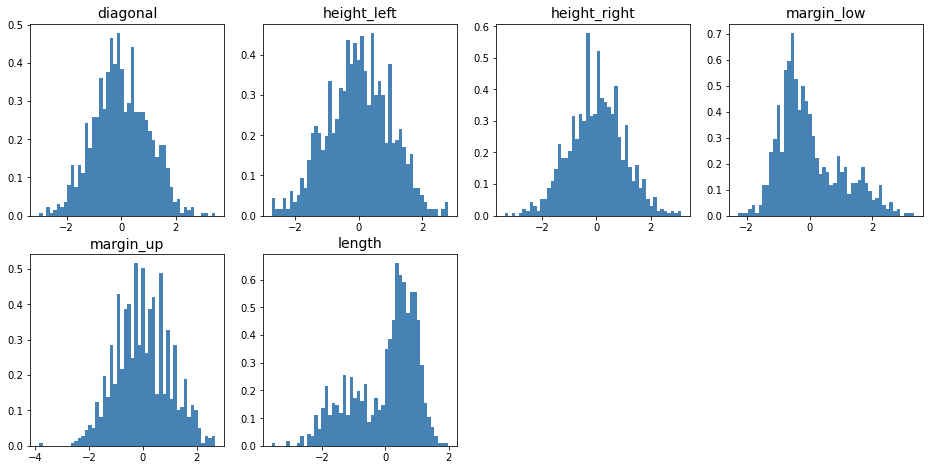

In [42]:
# Visualisation des variables centrées et réduites
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(X_knn.columns[feat_idx], fontsize=14)


In [43]:
# Détermination du nombre optimal de voisins (k) à utiliser pour le modèle kNN via GridSearchCV (validation croisée)

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train['is_genuine'])

# Afficher le(s) hyperparamètre(s) optimal/aux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement :")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['std_test_score'],  # écart-type du score
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement :
{'n_neighbors': 6}
Résultats de la validation croisée :
accuracy = 0.979 (+/-0.015) for {'n_neighbors': 2}
accuracy = 0.986 (+/-0.015) for {'n_neighbors': 3}
accuracy = 0.987 (+/-0.020) for {'n_neighbors': 4}
accuracy = 0.989 (+/-0.013) for {'n_neighbors': 5}
accuracy = 0.990 (+/-0.017) for {'n_neighbors': 6}
accuracy = 0.989 (+/-0.020) for {'n_neighbors': 7}
accuracy = 0.990 (+/-0.017) for {'n_neighbors': 8}
accuracy = 0.988 (+/-0.017) for {'n_neighbors': 9}
accuracy = 0.990 (+/-0.012) for {'n_neighbors': 10}
accuracy = 0.990 (+/-0.015) for {'n_neighbors': 12}
accuracy = 0.990 (+/-0.015) for {'n_neighbors': 15}
accuracy = 0.990 (+/-0.015) for {'n_neighbors': 20}


In [44]:
# Prédiction sur jeu de test pour calculer l'accuracy score
y_pred = clf.predict(X_test_std)
print("\nSur le jeu de test : {:.3f}".format(clf.score(X_test_std, y_test)))


Sur le jeu de test : 0.987


Accuracy: 0.9866666666666667
AUC-ROC: 0.9925460829493088


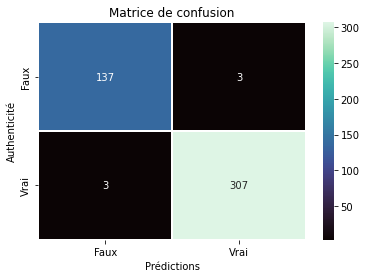

In [45]:
# Évaluer la qualité des prédictions sur jeu de test à l'aide d'une matrice de confusion
conf_matrix_knn = confusion_matrix(y_test, y_pred)

# Graphique :
sns.heatmap(conf_matrix_knn,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion")



# Calculer l'accuracy du modèle
accuracy = accuracy_score(y_test, y_pred)

# Calculer l'AUC-ROC du modèle
y_pred_proba = clf.predict_proba(X_test_std)[:,1] # Probabilités des classes positives
auc_roc = roc_auc_score(y_test, y_pred_proba)

# Afficher l'accuracy 
print("Accuracy:", accuracy)
# Afficher l'AUC-ROC
print("AUC-ROC:", auc_roc)

Le modèle a correctement identifié 137 observations positives (True Positive).

Le modèle a correctement identifié 307 observations négatives (True Negative).

Le modèle a effectué 6 erreur de classification: il a attribué une valeur reconnue comme False Positive pour 3 observations, et False Negative pour 3 autres.

Comme la matrice de confusion ne montre que 6 erreurs sur un total de 450 observations (98.6% de résultats corrects), on peut en conclure que le modèle a de très bonnes performances. 

## B - REGRESSION LOGISITIQUE

In [46]:
X = df_billet.copy()
y = pd.DataFrame(X['is_genuine'])   # colonne target
X = X.drop(columns = ['is_genuine']) # toutes les colonnes sauf la target "is_genuine"

# Séparation des données en train set et test set (70% pour l'entraînement et 30% pour les tests)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# Instancier le modèle de régression logistique
model = LogisticRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Prédire les valeurs sur les données de test
y_pred = model.predict(X_test)

# Évaluer la qualité des prédictions à l'aide d'une matrice de confusion
conf_matrix_regression_logistique = confusion_matrix(y_test, y_pred)

C:\Users\ptigr\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[138   2]
 [  2 308]]


Text(0.5, 1.0, 'Matrice de confusion')

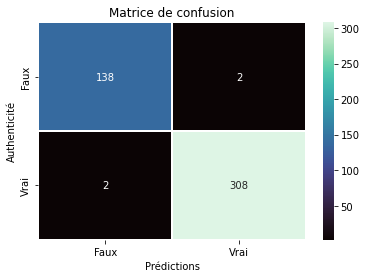

In [47]:
print(conf_matrix_regression_logistique)
# Graphique :
sns.heatmap(conf_matrix_regression_logistique,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion")

Le modèle a correctement identifié 138 observations positives (True Positive).

Le modèle a correctement identifié 308 observations négatives (True Negative).

Le modèle a effectué 4 erreurs de classification : il a attribué une valeur comme False Positive pour 2 observations et False Negative pour 2 autres.

Comme la matrice de confusion ne montre que 4 erreurs sur un total de 450 observations (99.1% de resultats corrects), on peut en conclure que le modèle a également de très bonnes performances. 

In [48]:
# Calculer l'accuracy du modèle
accuracy = accuracy_score(y_test, y_pred)

# Calculer l'AUC-ROC du modèle
y_pred_proba = model.predict_proba(X_test)[:,1] # Probabilités des classes positives
auc_roc = roc_auc_score(y_test, y_pred_proba)

# Afficher l'accuracy 
print("Accuracy:", accuracy)
# Afficher l'AUC-ROC
print("AUC-ROC:", auc_roc)

# Afficher les coefficients du modèle
coefficients = pd.DataFrame({'variable': X_train.columns, 'coef': model.coef_[0]})
print(coefficients)


Accuracy: 0.9911111111111112
AUC-ROC: 0.9993778801843318
       variable      coef
0      diagonal -0.291760
1   height_left -1.440831
2  height_right -1.978293
3    margin_low -3.289880
4     margin_up -2.864574
5        length  3.824727


Les résultats obtenus indiquent que le modèle de régression logistique est très performant :

L'accuracy est de 0.991, ce qui signifie que le modèle a correctement classé 99,1% des billets dans le bon groupe (authentique ou faux).
L'AUC-ROC est de 0.999, ce qui indique que le modèle est capable de distinguer avec une très grande précision les billets authentiques des faux billets.

Les variables qui ont le plus d'impact sur la probabilité qu'un billet soit authentique sont 'length' (coefficient positif) et 'margin_low' (coefficient négatif).

# V - CLASSIFICATION NON SUPERVISÉE (KMEANS)

In [49]:
# Setup du dataframe de base
df_kmeans = df_billet.loc[:,['diagonal','height_left','height_right','margin_low','margin_up','length']]
df_kmeans

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28
1496,172.19,104.63,104.44,5.27,3.37,110.97
1497,171.80,104.01,104.12,5.51,3.36,111.95
1498,172.06,104.28,104.06,5.17,3.46,112.25


In [50]:
# Listing des noms des variables dans un objet 'features'
features = df_kmeans.columns
features

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [51]:
# Centrer et réduire les données pour pouvoir les utiliser avec le kmeans
X = df_kmeans.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [52]:
# Visualisation des données centrées / réduites
X_scaled

array([[-0.48653957,  2.77412327,  3.16324041,  0.05569539, -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08103718, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12618182, -0.91256208,
         0.55190114],
       ...,
       [-0.51931643, -0.06524991,  0.61346228,  1.55618239,  0.89984645,
        -0.83501554],
       [ 0.3328817 ,  0.83666863,  0.42914097,  1.04086362,  1.33137229,
        -0.4911519 ],
       [-1.6009525 ,  0.40241156, -0.30814427,  0.22241617,  0.94299904,
        -0.69747008]])

In [53]:
# Création du PCA
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=2)

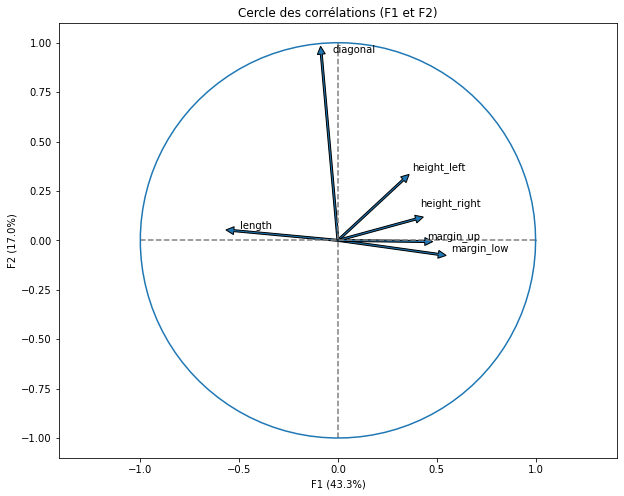

In [54]:
# Visualisation du cercle de corrélation
correlation_graph(pca, (0,1),features)

In [55]:
X_proj = pca.transform(X_scaled)

C:\Users\ptigr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


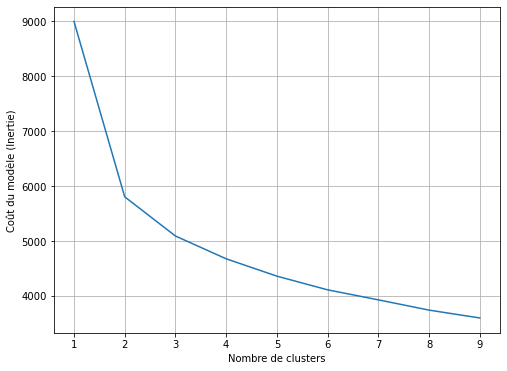

Inertie totale : 3597.5404352257856


In [56]:
# Méthode du coude: visualisation pour déterminer le nombre de clusters optimal
inertia = []
k_range=range(1,10)
for k in k_range:
    model_kmeans=KMeans(n_clusters=k, random_state=8).fit(X_scaled)
    inertia.append(model_kmeans.inertia_)
   
fig = plt.figure(figsize=(8,6))
plt.plot(k_range,inertia )
plt.xlabel('Nombre de clusters')
plt.ylabel('Coût du modèle (Inertie)')
plt.grid() 
plt.show()
print('Inertie totale :',model_kmeans.inertia_)

In [57]:
# Création du modèle avec un paramétrage pour 2 clusters (pour essayer de faire ressortir la distinction True / False)
model_km = KMeans(n_clusters=2, random_state=8)
km=model_km.fit(X_scaled)

# Prédiction via le modèle
results_kmeans=km.predict(X_scaled)

# Calcul pour faire en sorte que True=1 et False=0 (afin de pouvoir comparer facilement avec le dataframe de base)
values = 1 - results_kmeans

# Calcul de l'inertie totale
print('Inertie totale :',km.inertia_)

Inertie totale : 5804.7635406933805


Inertie totale : 2252.1461596929603


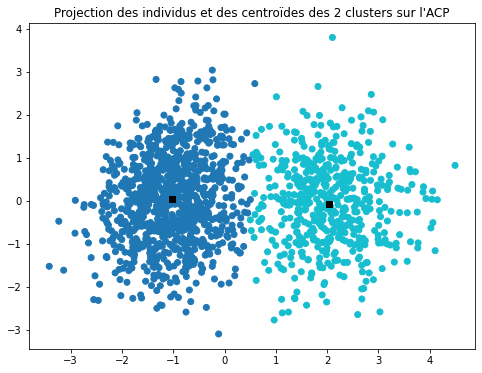

In [58]:
# Affichage du nuage de points (individus) en cluster avec les centroïdes
fig = plt.figure(figsize=(8,6))

model_km.fit(X_proj)
model_km.predict(X_proj)

plt.scatter(X_proj[:,0], 
            X_proj[:,1],
            c=model_km.predict(X_proj),cmap='tab10')
plt.scatter(model_km.cluster_centers_[:,0], 
           model_km.cluster_centers_[:,1],
           marker='s',c='black')

plt.title("Projection des individus et des centroïdes des 2 clusters sur l'ACP")
print('Inertie totale :',model_km.inertia_)


On distingue clairement les 2 clusters sur le graphique, il semble que la classification est étroitement lié à la valeur de la composante F1

In [59]:
values

array([0, 1, 1, ..., 0, 0, 0])

In [60]:
# Taille du jeu de test
values.shape

(1500,)

[[486  14]
 [ 10 990]]


Text(0.5, 1.0, 'Matrice de confusion')

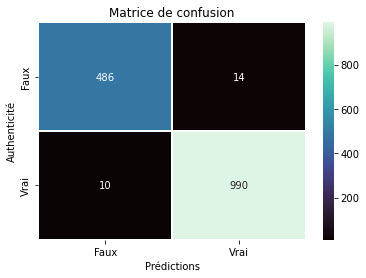

In [61]:
# Évaluer la qualité des prédictions à l'aide d'une matrice de confusion
conf_matrix_kmeans = confusion_matrix(df_billet['is_genuine'],values)

print(conf_matrix_kmeans)
# Graphique :
sns.heatmap(conf_matrix_kmeans,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion")

Le modèle a correctement identifié 990 observations positives (True Positive).

Le modèle a correctement identifié 486 observations négatives (True Negative).

Le modèle a effectué 24 erreurs de classification : il a attribué une valeur comme False Positive pour 14 observations et False Negative pour 10 autres.

Le taux d'observations correctement classifiées est 98.4%. On peut en conclure que le modèle non-supervisé a de très bonnes performances, mais qui restent inférieures à celles de la régression logistique. 

# VI - CHOIX DU MODELE

Après avoir testé les différents modèles de classification sur la base de notre set de donnée de test, voici le classement du plus efficace au moins efficace :

1 - Régression Logistique (supervisé) - accuracy = 99.1%

2 - Knn setup sur 7 voisins (supervisé) - accuracy = 98.6%

3 - Kmeans (non supervisé) - accuracy = 98.4%

On notera tout de même les très bonnes performances globales de l'ensemble des modèles.

Dans le cadre de notre projet, nous allons donc retenir le modèle de regression logistique qui semble le plus apte à classer les billets dans les catégories vrai/faux en fonction des variables disponibles dans les fichiers en input.

# VII - TEST DU MODELE RETENU 

In [62]:
def classifier_billets(nom_fichier, modele_a_appliquer):

    # Création du dataframe de test en chargeant le fichier csv
    fichier_test = pd.read_csv(nom_fichier,sep=',')
    id_column = fichier_test['id']
    fichier_test = fichier_test.drop(["id"],axis=1)

    # Standardisation des données
    std_scale = preprocessing.StandardScaler().fit(fichier_test)
    X_scaled = std_scale.transform(fichier_test)
    fichier_test.loc[fichier_test.index,"prediction_validite"] = modele_a_appliquer.predict(X_scaled)

    # Affichage des prédictions
    resultat = []
    for i in fichier_test['prediction_validite'] :
        if i == 1 :
            resultat.append('True')   
        else :
            resultat.append('False')

    fichier_test['prediction_validite'] = resultat
    
    # Jointure pour récupérer l'ID
    fichier_test['id'] = id_column
    
    # Affichage de l'ID des premiers faux billets
    display(fichier_test.loc[fichier_test['prediction_validite'] == 'False', ['id']])
    # Affichage du nombre total d'individus pour chaque valeur (vrai / faux)
    print(fichier_test['prediction_validite'].value_counts())
    

In [63]:
classifier_billets('billets_production.csv', model)

C:\Users\ptigr\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,id
0,A_1
1,A_2
2,A_3


False    3
True     2
Name: prediction_validite, dtype: int64
